In [267]:
%matplotlib inline
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import datetime
import pymc as pm
# from mpl_toolkits.basemap import Basemap
# from matplotlib.patches import Polygon

#set default plot characterstics and colors
from matplotlib import rcParams

import prep_data

dark_colors = ["#99D699", "#B2B2B2",
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 8)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = "white"
rcParams['axes.titlesize'] = 20      
rcParams['axes.labelsize'] = 17.5
rcParams['xtick.labelsize'] = 15 
rcParams['ytick.labelsize'] = 15
rcParams['legend.fontsize'] = 17.5
rcParams['patch.edgecolor'] = 'black'
rcParams['grid.color']="white"   
rcParams['grid.linestyle']="-" 
rcParams['grid.linewidth'] = 1
rcParams['grid.alpha']=1
rcParams['text.color'] = "444444"
rcParams['axes.labelcolor'] = "444444"
rcParams['ytick.color'] = "444444"
rcParams['xtick.color'] = "444444"

# import findspark
# findspark.init()
# import pyspark
# sc = pyspark.SparkContext(appName="Spark1")

In [87]:
stations_df = prep_data.stations('https://raw.githubusercontent.com/CS109Hubway/classp/master/data/hubway_stations.csv')
stations_df.head(1)

In [86]:
trips_df = prep_data.trips('https://raw.githubusercontent.com/CS109Hubway/classp/master/data/tripsthrough2012.csv')
trips_df.head(1)

In [35]:
day_set = set(trips_df.st_daydate.tolist())
day_set |= set(trips_df.end_daydate.tolist())
day_set = sorted(list(day_set))

In [45]:
out_minutes_series = np.zeros([trips_df.strt_statn.max() + 1,len(trips_df.st_daydate.unique())*24*60])
in_minutes_series = np.zeros([trips_df.end_statn.max() + 1,len(trips_df.end_daydate.unique())*24*60])

for index, row in trips_df.iterrows():
    print "\r" + str(index),
    
    if row[6] != row[6]:
        continue
    
    st_station  = row[6]
    st_minute   = row[16]
    st_day = day_set.index(row[20])    

    out_minutes_series[st_station,st_day*24*60 + st_minute] += 1

    if row[8] != row[8]:
        continue

    end_station = row[8]
    end_minute  = row[17]    
    end_day = day_set.index(row[21])
    
    in_minutes_series[end_station, end_day*24*60 + end_minute] += 1


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


533828


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


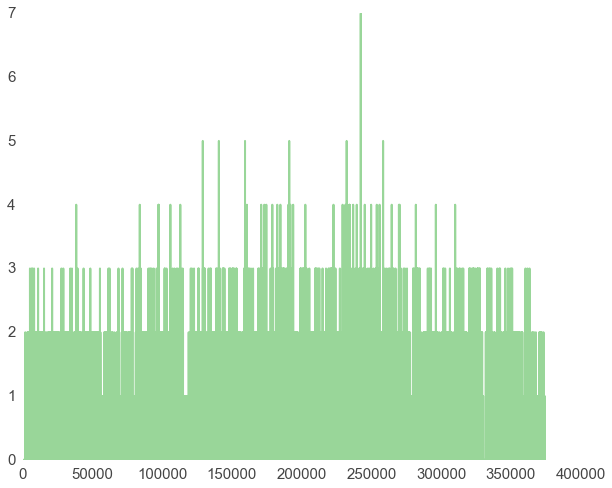

In [185]:
plt.plot(out_minutes_series[22,:])

In [198]:
min_per_interval = 60
ints = 0
timeseries_matrix_60minute_out = np.zeros(len(out_minutes_series[22,:])/min_per_interval)
while ints < len(timeseries_matrix_60minute_out):
    int_sum = 0
    for i in range(min_per_interval):
        int_sum += out_minutes_series[22,ints*min_per_interval + i]
    timeseries_matrix_60minute_out[ints] = int_sum
    ints +=1

In [230]:
min_per_interval = 30
ints = 0
timeseries_matrix_30minute_out = np.zeros(len(out_minutes_series[22,:])/min_per_interval)
while ints < len(timeseries_matrix_30minute_out):
    int_sum = 0
    for i in range(min_per_interval):
        int_sum += out_minutes_series[22,ints*min_per_interval + i]
    timeseries_matrix_30minute_out[ints] = int_sum
    ints +=1

(0, 15)

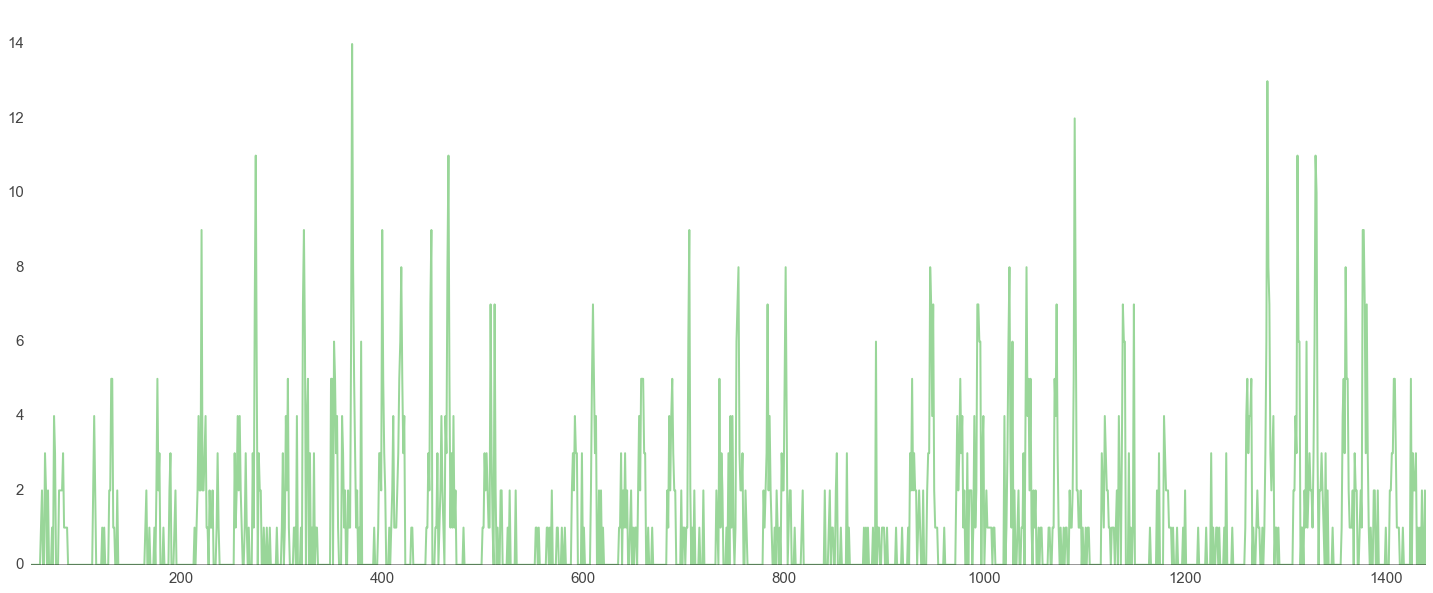

In [296]:
plt.figure(figsize=[25,10])
plt.plot(timeseries_matrix_30minute_out)
plt.axhline(0,color = "k",alpha = .4 )
plt.axvline(0,color = "k",alpha = .4 )
# plt.ylabel("Number Bike Rentals")
# plt.xlabel("30 Minute Interval")
# plt.title("South Station Bike Rentals every 30 Minutes")
plt.xlim(50,1440)
plt.ylim(0,15)

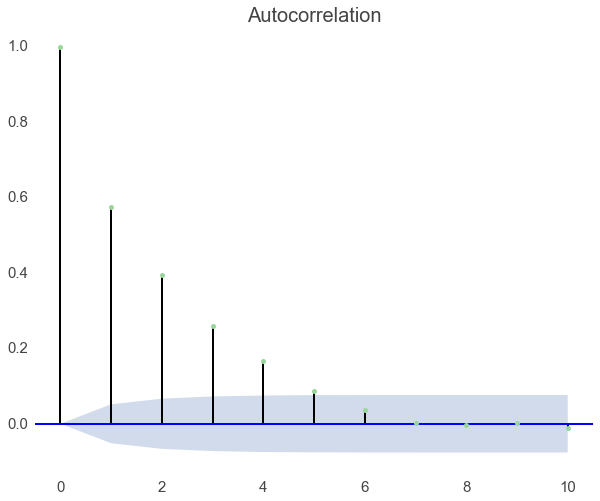

In [232]:
tsaplots.plot_acf(timeseries_matrix_30minute_out[:1440], lags=10);

In [306]:
#estimate these
N = 1440
AR = 5

# a1n(xn-1) + a2n(xn-2) + a3n(xn-3) +a4n(xn-4) + a5n(xn-5)

alphas = pm.Container([pm.Uniform('alpha_%i' %i,lower = -10,upper = 10) for i in range(AR)])

sigma_squared = pm.Uniform('sigma_squared',lower=0,upper=10)

mus = pm.Container([alphas[0]*timeseries_matrix_30minute_out[i-1] + \
                    alphas[1]*timeseries_matrix_30minute_out[i-2] + \
                    alphas[2]*timeseries_matrix_30minute_out[i-3] + \
                    alphas[3]*timeseries_matrix_30minute_out[i-4] + \
                    alphas[4]*timeseries_matrix_30minute_out[i-5] \
                    for i in range(AR,N)])

#init_likelihood = pm.Normal('init_likelihood', mu = 0, tau = 1/sigma_squared, value = timeseries_matrix_30minute_out[0], observed = True)

likelihood = pm.Container([pm.Normal('likelihood_%i' %i, mu = mus[i-AR], tau = 1.0/sigma_squared, value = timeseries_matrix_30minute_out[i], observed = True) for i in range (AR,N)])

posterior = pm.Model([alphas, mus, sigma_squared, likelihood])

mcmc = pm.MCMC(posterior)
mcmc.sample(iter=10000,burn=100)

 [-----------------100%-----------------] 10000 of 10000 complete in 2435.9 sec

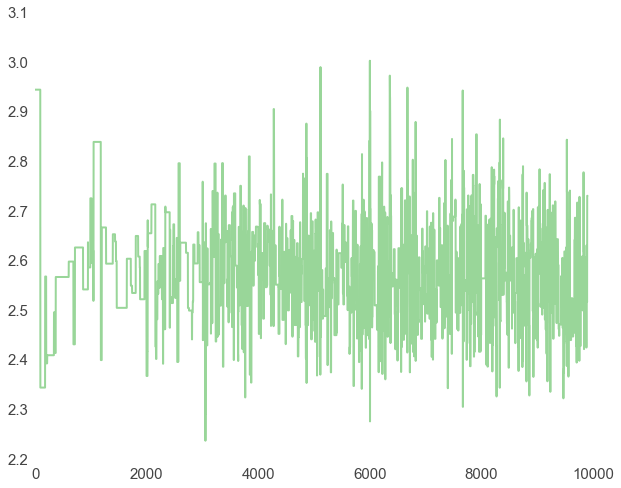

In [307]:
plt.plot(sigma_squared.trace())

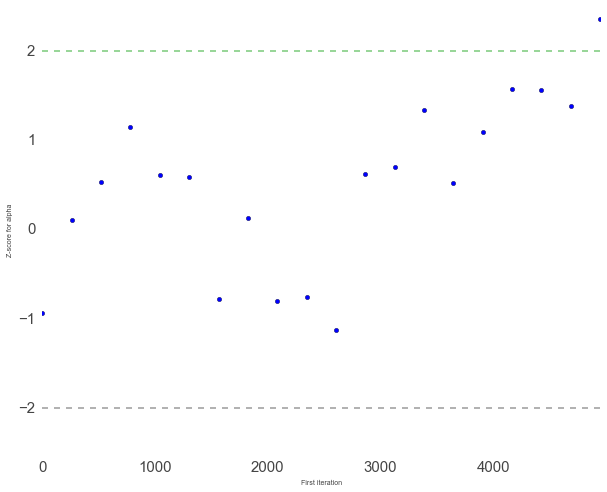

In [311]:
geweke_scores = pm.geweke(alphas[1].trace(), first =0.1, last=0.5, intervals=20)
pm.Matplot.geweke_plot(geweke_scores, "alpha")

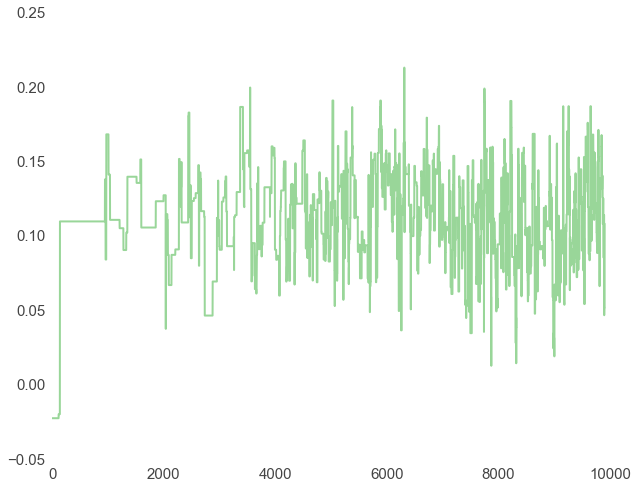

In [308]:
plt.plot(alphas[1].trace())

In [237]:
mcmc_sigma_squared = np.mean(sigma_squared.trace())
mcmc_sigma_squared

2.8086942522254903

In [238]:
# Infer alpha
mcmc_alphas = [np.mean(alphas[i].trace()) for i in xrange(AR)]
mcmc_alphas

[0.59772828472590078,
 0.15396443018124487,
 -0.15757090920972328,
 0.14728371023445783,
 0.0080812165089825683]

In [239]:
# Sample from Posterior Predictive
# Number of samples
num_sims = 500

next_six_predictions = np.zeros((5,num_sims))
for i in xrange(num_sims):
    #Predict t = N
    next_six_predictions[0,i] = np.max((np.dot(timeseries_matrix_30minute_out[N-5:N],mcmc_alphas) + np.random.normal(0,np.sqrt(mcmc_sigma_squared)),0))

    # Predict t = N
    next_six_predictions[1,i] = np.max((np.dot(np.concatenate([timeseries_matrix_30minute_out[N-4:N].reshape(1,4),next_six_predictions[0,i].reshape(1,1)],axis=1)[0],mcmc_alphas[::-1]) \
                + np.random.normal(0,np.sqrt(mcmc_sigma_squared)),0))

    # Predict t = N+1
    next_six_predictions[2,i] = np.max((np.dot(np.concatenate([timeseries_matrix_30minute_out[N-3:N].reshape(1,3),next_six_predictions[:2,i].reshape(1,2)],axis=1)[0],mcmc_alphas[::-1]) \
                + np.random.normal(0,np.sqrt(mcmc_sigma_squared)),0))
    # Predict t = N+2
    next_six_predictions[3,i] = np.max((np.dot(np.concatenate([timeseries_matrix_30minute_out[N-2:N].reshape(1,2),next_six_predictions[:3,i].reshape(1,3)],axis=1)[0],mcmc_alphas[::-1]) \
                + np.random.normal(0,np.sqrt(mcmc_sigma_squared)),0))
    # Predict t = N+3
    next_six_predictions[4,i] = np.max((np.dot(np.concatenate([timeseries_matrix_30minute_out[N-1:N].reshape(1,1),next_six_predictions[:4,i].reshape(1,4)],axis=1)[0],mcmc_alphas[::-1]) \
                + np.random.normal(0,np.sqrt(mcmc_sigma_squared)),0))

# Choose a prediction
print "Prediction of checkouts for t = {}: {}".format(N,next_six_predictions[0,0])
print "Prediction of checkouts for t = {}: {}".format(N+1,next_six_predictions[1,0])
print "Prediction of checkouts for t = {}: {}".format(N+2,next_six_predictions[2,0])
print "Prediction of checkouts for t = {}: {}".format(N+3,next_six_predictions[3,0])
print "Prediction of checkouts for t = {}: {}".format(N+4,next_six_predictions[4,0])


Prediction of checkouts for t = 1440: 1.68538120105
Prediction of checkouts for t = 1441: 1.37226295468
Prediction of checkouts for t = 1442: 0.774960153029
Prediction of checkouts for t = 1443: 0.0
Prediction of checkouts for t = 1444: 0.0


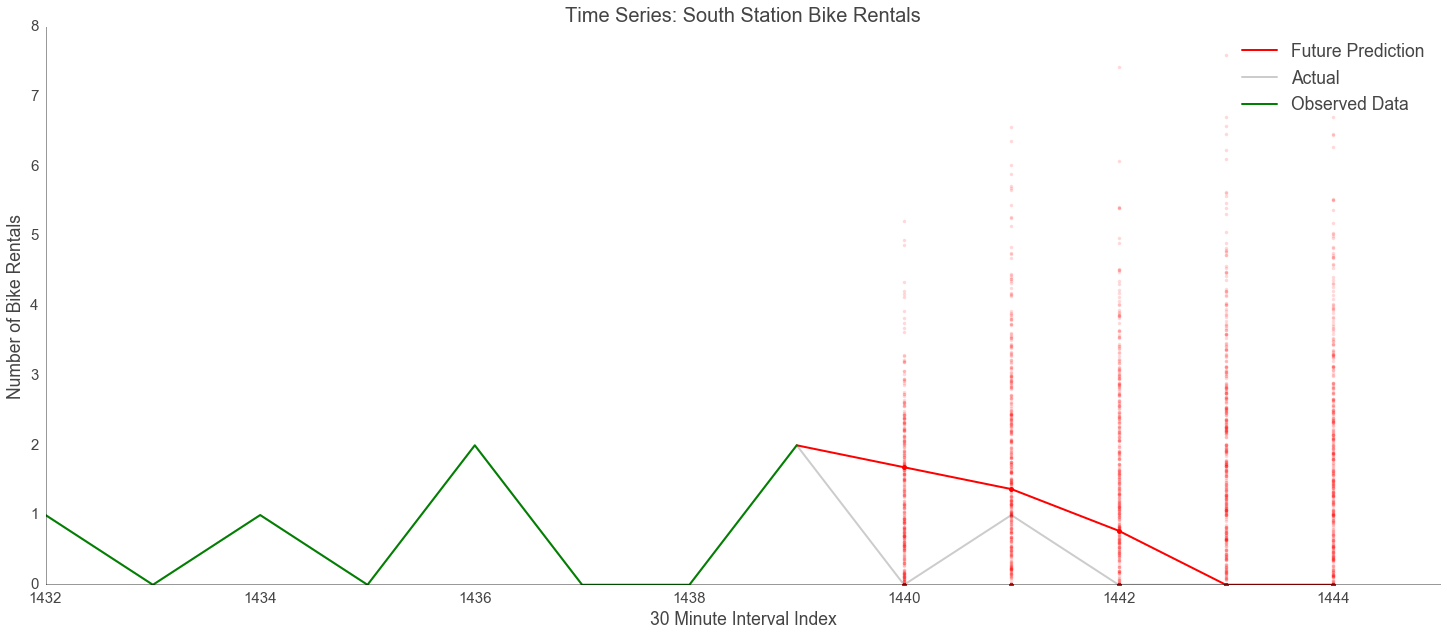

In [297]:
plt.figure(1,(25,10))

# plot all new predictions
plt.plot(np.repeat(np.arange(N,N+AR),num_sims),next_six_predictions.flatten(),\
         '.',alpha=.15,color='r')

# plot new predictions connected to observed data
plt.plot(np.arange(N-1,N+AR),np.concatenate([np.array([timeseries_matrix_30minute_out[N-1]]),\
                                             next_six_predictions[:,0]]),color='r',label="Future Prediction")

#plot other future predictions as points
plt.plot(np.arange(N,N+AR),next_six_predictions[:,0],'.',color='r',markersize=10)
plt.plot(timeseries_matrix_30minute_out[:N+AR],label = "Actual", color = "k", alpha = 0.2)
plt.plot(np.arange(0,N),timeseries_matrix_30minute_out[:N],label="Observed Data", color = "g")
plt.legend()
plt.xlim(N-8,N+5)
plt.ylim(0,8)
plt.title("Time Series: South Station Bike Rentals")
plt.xlabel("30 Minute Interval Index")
plt.ylabel("Number of Bike Rentals")
plt.axhline(0,color = "k",alpha = .4 )
plt.axvline(N-8,color = "k",alpha = .4 )